# Flooring Damage and Decay  Identification 

*by: Fellow Team Austin*

This project is organized into following parts:

- Introduction 
- Importing necessary tools
- Data collection
- Exploration data analysis
- Data visualization
- Data preprocessing
- Building the  Model
- Evaluating the Model
- Improving the Model 
- Conclusion








## Introduction : Problem Statement

The aim of this project is to build a Deep Learning model that will be able to distinguish damaged or decay flooring against flooring in good condition for a Real-Estate application purpose. Solving such problem, We need to understand very well what the problem is and what the data looks like before we can figure out how to solve it.

The first step we took approaching this problem was  to take a look at the data needed to build the model. we identified 4 types of flooring including: **laminate, tile, ceramic** and **wooden**. Next step will then consists of collecting, cleaning and orginizing data for each class, thereafter build the model. For the model training purpose data directories are structured as follows: 


| flooring_type | Folder names | Label names |
|      ---      |      ---     |      ---    |
| Laminate      | DamagedLam   | DamagedLam  |
|               | NormalLam    | NormalLam   |
|                                            |
| Tile          | DamagedTile  | DamagedTile |
|               | NormalTile   | NormalTile  |
|                                            |
| Ceramics      | Damagedcer   | DamagedCer  |
|               | NormalCer    | NormalCer   |
|                                            |
| Wooden        | DamagedWoo   | DamagedWoo  |
|               | NormalWoo    | NormalWoo   |

For each type of flooring we will have damaged and normal images and labels named after the folders as show in table. The rest of this document will be organized as stated above.

## Importing necessary tools

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.hooks import *

import matplotlib.pyplot as plt

## Data collection: 

We used "Google Images" as a source of our data. Following are steps to accomplish the task:


- **Go to [Google Images](http://images.google.com)** and search for **flooring damage and decay images**.

- **Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd>** in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. Paste the following JavaScript commands into that window:

- ```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

- **Image file paths (urls) will be downloaded**, next upload them to the notebook and use them to download images



-  **Downloaded images** : images from their respective urls are stored as indicated below:
    - [x] urls source folder: Specified as **Dataset1**
    - [x] Image destination folder: Specified as **Damaged** and **Normal**


In [0]:


#Upload the zipped file (Dataset1.zip : containing images files urls):

from zipfile import ZipFile
file_name= "Dataset1.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:

#Creating folders to hold the images  downloaded from the urls

folders = ['DamagedLam','NormalLam']
files = ['DamagedLam.txt','NormalLam.txt']

folders_files = []
for i in range(0,len(folders)):
    folders_files.append((folders[i],files[i]))


#Declaring the root folder that will contain everything
path = Path('/content/Dataset1')


#Downloading images from urls to specified folders
for folder,file in folders_files:
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(path/file, dest, max_pics=200) 



In [0]:
#Then we remove any images that can't be opened and Verifying the maximum number of image we need to keep per class
classes = ['DamagedLam','NormalLam']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## Exploration Data Analysis

In this section we check on the root folder contents and databanch structure :the number of classes we are going to train with, the total images and both training and validation split portions.

In [0]:
#Desplaying the root folder content
path.ls()

[PosixPath('/content/Dataset1/DamagedLam'),
 PosixPath('/content/Dataset1/DamagedLam.txt'),
 PosixPath('/content/Dataset1/NormalLam.txt'),
 PosixPath('/content/Dataset1/NormalLam')]

In [0]:
# Go get all of images from FOLDERS located at Path('/content/data':images downloaded) 
# Then split images for training and validation purpose
# The names of the image folders will be the names of classes in this case(labels)

np.random.seed(42)
bs=64 
size=224
#tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)
#ds_tfms=get_transforms()

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=size, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['DamagedLam', 'NormalLam'], 2, 293, 73)

## Data visualization

Let's take a look at some of our images in our dataset



We are going to use our owner built dataset which features 4 categories of flooring each with Damaged and Normal data. Thus our model will need to learn to differentiate between 8 distinct categories. Let's see how some of those images look like!

/content/Dataset1/DamagedLam/00000176.jpg


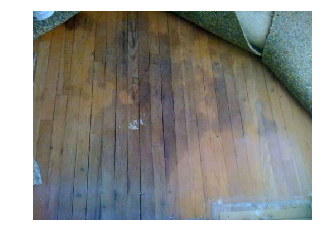

In [0]:

#Damaged Images
fnames = get_image_files(path/'DamagedLam')
print(fnames[1])

img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

/content/Dataset1/NormalLam/00000083.jpg


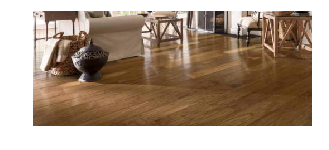

In [0]:
#Normal Images
fnames = get_image_files(path/'NormalLam')
print(fnames[7])

img_f = fnames[7]
img = open_image(img_f)
img.show(figsize=(5,5))

Next is our databach look

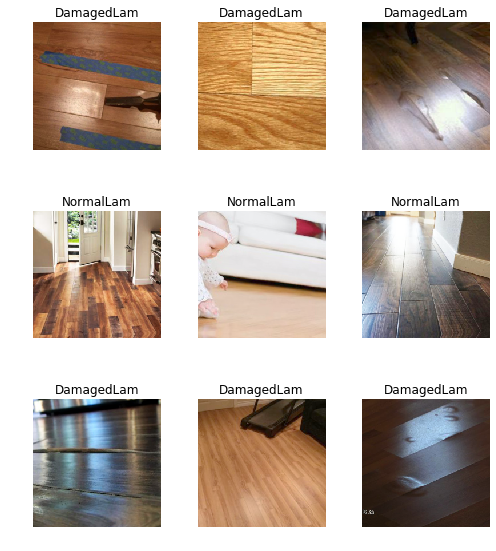

In [0]:
data.show_batch(rows=3, figsize=(7,8))

## Train model


Now we will start training our model. We will use a convolutional neural network backbone and resnet50 (a pretrained model).The idea behind the resnet50 in our project is to use transfer learning for  classification task. Our  model is initialized with the weights of a model pretrained on a larger number of several images classes (not randomly initialized as usual ML does it). 

We then build a model which will take images as input and  outputs the predicted probability for each of the categories (in this case, it will have 8 outputs).

In [0]:

learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 109817680.65it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


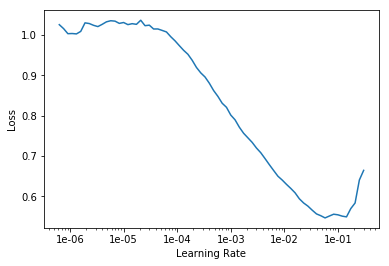

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#We will train for 4 epochs (4 cycles through all our data)
learn.fit_one_cycle(4, max_lr=slice(1e-2,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.133627,28.404270,0.506849,00:13
1,1.126000,5.432811,0.424658,00:08
2,1.213010,6.587373,0.438356,00:09
3,1.124057,2.144286,0.219178,00:09


In [0]:
learn.save('stage-1')

In [0]:
#Now we will unfreeze our model and train more.
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


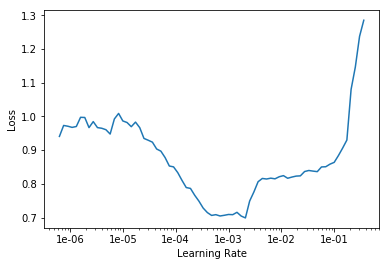

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [0]:

#activation fn :
#Optimizer: SDG or Adam
#lr
#wd=0.1
#moms=(0.8,0.7)
#dropout
#pct_start=0.3

learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-3))


epoch,train_loss,valid_loss,error_rate,time
0,0.878057,0.747122,0.164384,00:10
1,0.771039,0.630243,0.191781,00:10
2,0.710174,1.197032,0.136986,00:10
3,0.623223,1.731376,0.246575,00:10
4,0.561494,2.627097,0.219178,00:10
5,0.510203,2.683717,0.260274,00:10
6,0.463140,1.968717,0.191781,00:10
7,0.421038,1.441865,0.178082,00:10
8,0.384857,1.041791,0.191781,00:10
9,0.360396,0.811873,0.191781,00:10


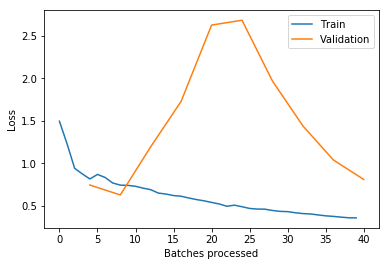

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2')

## Model Evaluation

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

### Accuracy

In [0]:

pred,label= learn.get_preds()
accuracy(pred, label)

tensor(0.8082)

### Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

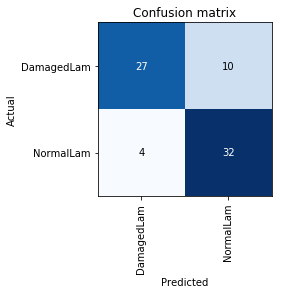

In [0]:
interp.plot_confusion_matrix()

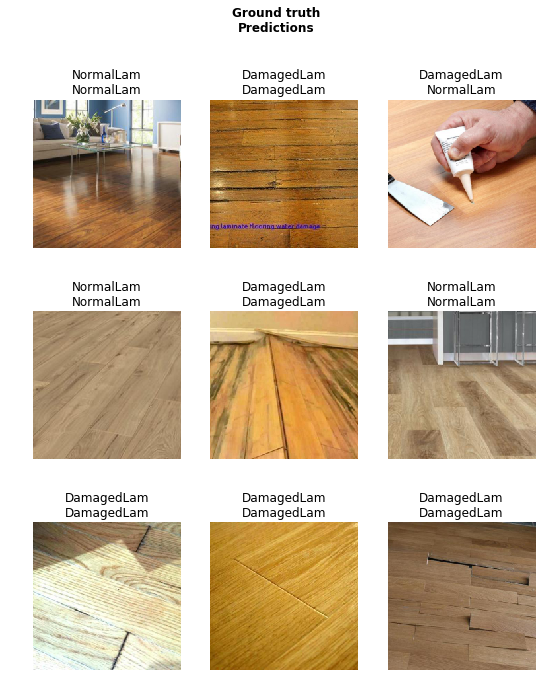

In [0]:
learn.show_results(rows=3, figsize=(9,11)) #

Model summary displayed below

In [0]:
print(learn.summary()) #

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
___________________________________________________

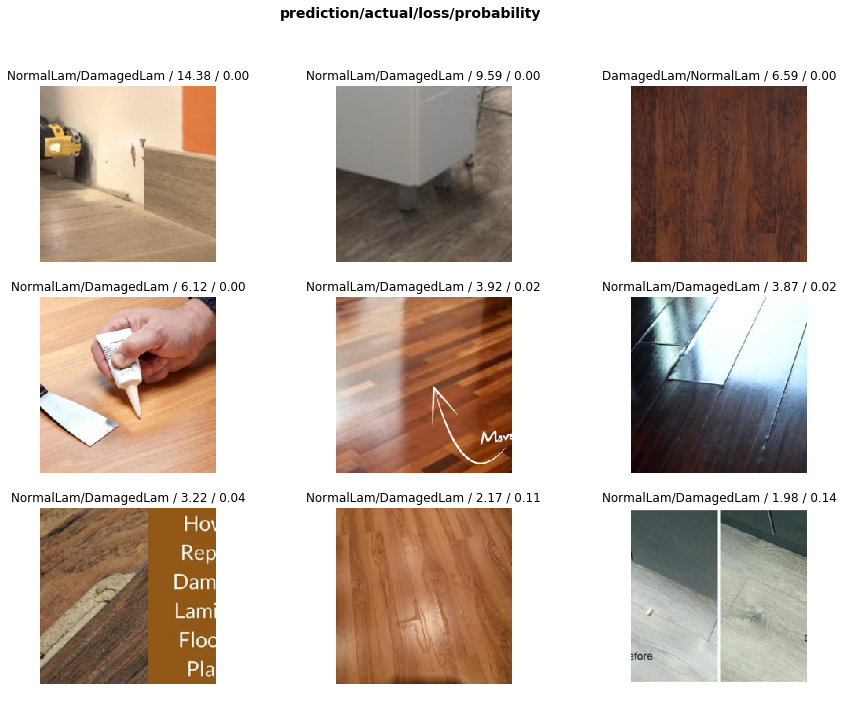

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are **images in our data set that shouldn't be.**

**Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong**.

In [0]:
from fastai.widgets import *

**First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`**.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .no_split()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

Then we create a new learner to use our new databunch with all the images.

In [0]:
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)

learn_cln.load('stage-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [0]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.



#ImageCleaner(ds, idxs, path)


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [0]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [0]:
#ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

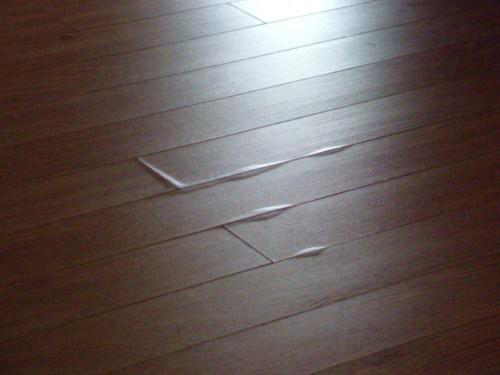

In [0]:
img = open_image('/content/Dataset1/DamagedLam/00000004.jpg')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category DamagedLam

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)